In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install fastparquet
!pip install --upgrade numpy

     |████████████████████████████████| 15.7 MB 182 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import re
import pandas as pd
import numpy as np

os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from pred_functions import combine_files_into_acquisitions, post_processing

# Fetch the files 
os.chdir('/content/gdrive/My Drive/data/SWINGS/Preds/')
#pred_folders =  ['preds1', 'preds2']
sum_files_repo = '/content/gdrive/My Drive/data/volumes'

pulse_regex = "Pulse" 
date_regex = "Pulse[0-9]{1,2}_(20[0-9]{2}-[0-9]{2}-[0-9]{2} [0-9]{2}(?:u|h)[0-9]{2})"
flr_regex = 'Pulse([0-9]{1,2})' #flr5 ou flr25

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pred_folder = 'Done'

In [ ]:
phyto_ts = pd.DataFrame(columns = ['NANO',\
                   'inf1microm', 'MICRO',\
                'REDPICO', 'sup1microm', 'ORGPICOPRO', 'date', 'FLR', 'file'])

In [ ]:
pred_files = os.listdir(pred_folder)
files = [file for file in pred_files if re.search(pulse_regex, file)] # The files containing the data to predict
  
for file in files:

    flr_num = int(re.search(flr_regex, file).group(1))
    path = pred_folder + '/' + file
    cl_count = pd.read_csv(path, usecols = ['Pred FFT Label', 'Total FWS', 'Total SWS']) #lit le fichier et le classe en trois colonnes
    #cl_count = post_processing(cl_count, flr_num)    #dans pred_functions, change la classe de certaines particules 
    cl_count = cl_count['Pred FFT Label'].value_counts() #compte le nombre de particules dans chaque classe
    cl_count = pd.DataFrame(cl_count).transpose() #met sous forme de tableau+échange lignes et colonnes

    # Keep only "big" phyotplancton from FLR25 and "small" one from FLR6 
    '''
    if flr_num == 20:
      cl_count[['ORGPICOPRO']] = 0
    else:
      cl_count[['REDPICO', 'NANO', 'MICRO']] = 0
    '''
    
    # Compute the volume
    
    sep = '-' if flr_num == 6 else '_'
    date = re.search(date_regex, file).group(1)  
    sum_file = 'SSLAMM' + sep + 'FLR' + str(flr_num) + ' ' + date + '_Info.txt'
    '''
    try:
      with open(sum_files_repo + '/' + sum_file) as f:
        lines = f.readlines()
        vol = re.search('Volume .+: ([0-9]+,[0-9]+)', str(lines)).group(1)
        vol = float(re.sub(',', '.', vol))

    except FileNotFoundError:
      print(file, ' volume was not found')
      continue

    # If the volume analyzed is too small then the quality of the data is 
    # not guaranteed
    if (flr_num == 25) & (vol <= 1500):
        continue
    if (flr_num == 6) & (vol <= 350):
        continue
    
     
    # Compute the concentration (also called abundance)
    cl_count = cl_count.div(int(vol)) #divise toutes les colonnes par le volume total -> donne la concentration
    '''

    # The timestamp is rounded to the closest hour
    date = pd.to_datetime(date, format='%Y-%m-%d %Hh%M', errors='ignore')
    date = date.round('2H')
           
    cl_count['date'] = date #ce qu'on met dans la colonne date
    cl_count['FLR'] = flr_num 
    cl_count['file'] = file 

    #print(cl_count)
    #print(phyto_ts)

    # New format:
    phyto_ts = phyto_ts.append(cl_count)


# Deal with incomplete acquisitions

In [ ]:
from copy import deepcopy
phyto_ts_backup = deepcopy(phyto_ts)
phyto_ts = combine_files_into_acquisitions(phyto_ts) #les prédictions FLR5 et 20 sont combinées

In [ ]:
phyto_ts

,NANO,inf1microm,MICRO,REDPICO,sup1microm,ORGPICOPRO,date,FLR,file
Pred FFT Label,0,22394,0,0,2207,38,2021-02-23 10:00:00,5,Pulse5_2021-02-23 10h11.csv
Pred FFT Label,0,40871,0,0,1689,69,2021-02-16 14:00:00,5,Pulse5_2021-02-16 14h11.csv
Pred FFT Label,0,30993,0,0,3767,4279,2021-03-01 10:00:00,5,Pulse5_2021-03-01 10h11.csv
Pred FFT Label,0,48015,0,0,3203,803,2021-03-01 20:00:00,5,Pulse5_2021-03-01 20h11.csv
Pred FFT Label,0,70644,0,0,3613,133,2021-03-01 00:00:00,5,Pulse5_2021-03-01 00h11.csv
...,...,...,...,...,...,...,...,...,...
Pred FFT Label,0,107307,0,0,3021,1008,2021-02-09 20:00:00,5,Pulse5_2021-02-09 20h11.csv
Pred FFT Label,0,114987,0,0,4001,1089,2021-02-09 22:00:00,5,Pulse5_2021-02-09 22h11.csv
Pred FFT Label,0,122681,0,0,5525,1138,2021-02-10 00:00:00,5,Pulse5_2021-02-10 00h11.csv
Pred FFT Label,0,134323,0,0,5740,1148,2021-02-10 02:00:00,5,Pulse5_2021-02-10 02h11.csv


In [ ]:
phyto_ts

,NANO,inf1microm,MICRO,REDPICO,sup1microm,ORGPICOPRO,date,FLR,file
Pred FFT Label,670,22394,63,1899,2207,38,2021-02-23 10:00:00,5,Pulse5_2021-02-23 10h11.csv
Pred FFT Label,479,40871,8,3037,1689,69,2021-02-16 14:00:00,5,Pulse5_2021-02-16 14h11.csv
Pred FFT Label,1066,30993,68,24540,3767,4279,2021-03-01 10:00:00,5,Pulse5_2021-03-01 10h11.csv
Pred FFT Label,643,48015,38,9462,3203,803,2021-03-01 20:00:00,5,Pulse5_2021-03-01 20h11.csv
Pred FFT Label,1662,70644,47,6905,3613,133,2021-03-01 00:00:00,5,Pulse5_2021-03-01 00h11.csv
...,...,...,...,...,...,...,...,...,...
Pred FFT Label,1101,107307,69,20143,3021,1008,2021-02-09 20:00:00,5,Pulse5_2021-02-09 20h11.csv
Pred FFT Label,1108,114987,68,21993,4001,1089,2021-02-09 22:00:00,5,Pulse5_2021-02-09 22h11.csv
Pred FFT Label,1250,122681,63,23778,5525,1138,2021-02-10 00:00:00,5,Pulse5_2021-02-10 00h11.csv
Pred FFT Label,2009,134323,81,25762,5740,1148,2021-02-10 02:00:00,5,Pulse5_2021-02-10 02h11.csv


In [ ]:
phyto_ts.to_csv('/content/gdrive/My Drive/data/SWINGS/SWINGS_preds06212021.csv')

In [ ]:
phyto_ts_backup

,NANO,inf1microm,MICRO,REDPICO,sup1microm,ORGPICOPRO,date,FLR
Pred FFT Label,0,22394,0,0,2207,38,2021-02-23 10:00:00,5
Pred FFT Label,0,40871,0,0,1689,69,2021-02-16 14:00:00,5
Pred FFT Label,0,30993,0,0,3767,4279,2021-03-01 10:00:00,5
Pred FFT Label,0,48015,0,0,3203,803,2021-03-01 20:00:00,5
Pred FFT Label,0,70644,0,0,3613,133,2021-03-01 00:00:00,5
...,...,...,...,...,...,...,...,...
Pred FFT Label,0,107307,0,0,3021,1008,2021-02-09 20:00:00,5
Pred FFT Label,0,114987,0,0,4001,1089,2021-02-09 22:00:00,5
Pred FFT Label,0,122681,0,0,5525,1138,2021-02-10 00:00:00,5
Pred FFT Label,0,134323,0,0,5740,1148,2021-02-10 02:00:00,5


Text(0, 0.5, 'cell/$\\mu{l}$')

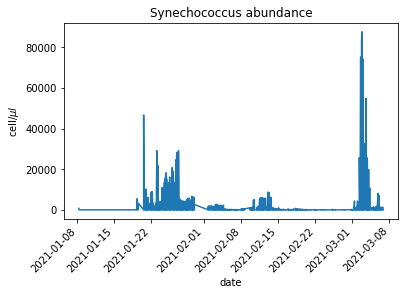

In [ ]:
import matplotlib.pyplot as plt

phyto_ts_backup.set_index('date')['ORGPICOPRO'].plot()
plt.xticks(rotation = 45)
plt.title('Synechococcus abundance')
plt.ylabel('cell/$\mu{l}$')